In [3]:
%reset
import sys, platform, os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pdb
from astropy.io import fits
from scipy import interpolate
import astropy.units as u
import pickle as pk
from astropy import constants as const
import notebook_calc_3d_to_2d_new as nc
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=100, Om0=0.25, Tcmb0=2.725, Ob0=0.0448)
h = 0.7
oneMpc_h = (((10 ** 6) / h) * (u.pc).to(u.m))
import copy

#see http://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

%matplotlib inline






Initializing k-grid quantities...
Warning, you selected a extrap_low that is greater than k_min. Therefore no extrapolation will be done.
processing Pk Plin
processing Pk Pmm
processing Pk Pd1d2
processing Pk Pd2d2
processing Pk Pd1s2
processing Pk Pd2s2
processing Pk Ps2s2
processing Pk Pd1d3nl
processing Pk k2Pk
processing Pk sig4


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Cosmology functions

# get comoving distance
def get_Dcom_array(zarray, Omega_m):
    Omega_L = 1. - Omega_m
    c = 3 * 10 ** 5
    Dcom_array = np.zeros(len(zarray))
    for j in xrange(len(zarray)):
        zf = zarray[j]
        res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
        Dcom = res1[0]
        Dcom_array[j] = Dcom
    return Dcom_array

# get 100 times dimensionless hubble constant as a function of redshift
def get_Hz(zarray, Omega_m):
    Omega_L = 1 - Omega_m
    Ez = np.sqrt(Omega_m * (1 + zarray) ** 3 + Omega_L)
    Hz = 100. * Ez
    return Hz

def get_zmean(zcent, nz_bin):
    prob_zcent = nz_bin
    delz = zcent[1] - zcent[0]
    zmean = (np.sum(prob_zcent * zcent * delz)) / (np.sum(prob_zcent * delz))
    return zmean







In [5]:
# wtheta and gammat functions:

# coeff_sigcrit = ((const.c ** 2)/(4 * np.pi * const.G * (1.0 * u.Mpc))).to(u.kg/u.m**2)).value
# # get critical surface density (eq.9)
# def get_sigcrit_zl_zs(zl,zs, Om, Dcom_interp):
#     chi_l = Dcom_interp(zl)
#     chi_s = Dcom_interp(zs)
#     DA_l = (chi_l/(1. + zl))
#     DA_s = (chi_s / (1. + zs))
#     DA_ls = ( (chi_s- chi_l) / (1. + zs))
#     sigcrit =  ((coeff_sigcrit * (DA_s)/(DA_l * DA_ls))
#     return sigcrit

# get projected correlation function (eq.2)
def get_wprp_from_xi(rp,r_array,xi_array):
    num = r_array * xi_array
    denom = np.sqrt(r_array**2 - rp**2)
    toint = num/denom
    val = 2.*sp.integrate.simps(toint,r_array)
    return val

# # get w(theta) (eq 3)
# def get_wtheta_from_xi(theta, r_array,xi_array, z_array, ng, chi_array, dchi_dz):
#     rp_array = chi_array*theta
#     wprp_array = np.zeros(len(rp_array))

#     for j in range(len(rp_array)):
#         rp = rp_array[j]
#         ind_inp = np.where(r_array > rp)[0]
#         r_inp = r_array[ind_inp]
#         xi_inp = xi_array[j,ind_inp]
#         wprp_array[j] = get_wprp_from_xi(rp, r_inp, xi_inp)

#     toint = ng**2 * wprp_array / dchi_dz
#     val = sp.integrate.simps(toint,z_array)

#     return val

# # get gammat for a single lens and source redshift (Eq.12)
# def get_Delta_wp(rp, r_array,xi_array, r_array_full,xi_array_full):

#     rp_ti = np.logspace(-2,np.log10(rp),50)
#     wprp_ti = np.zeros(len(rp_ti))
#     for j in range(len(rp_ti)):
#         rp_ti_h = rp_ti[j]

#         ind_inp = np.where(r_array_full > rp_ti_h)[0]
#         r_inp = r_array_full[ind_inp]
#         xi_inp = xi_array_full[j,ind_inp]

#         wprp_ti[j] = get_wprp_from_xi(rp_ti_h,r_inp, xi_inp)

#     # wp_int = (2./ (rp**2) )*sp.integrate.simps(rp_ti * wprp_ti, rp_ti)
#     wp_int = sp.integrate.simps(rp_ti * wprp_ti, rp_ti)/sp.integrate.simps(rp_ti , rp_ti)
#     wp_val = get_wprp_from_xi(rp,r_array,xi_array)
#     Delta_wp = wp_int - wp_val

#     return Delta_wp

# get w(theta) (eq 3)
def get_wtheta_from_xi(theta, r_array,xi_mat, z_array, ng, chi_array, dchi_dz):
    rp_array = chi_array*theta
    
    r_mat = np.tile(r_array.reshape(1,len(r_array)),(len(z_array),1))
    rp_mat = np.tile(rp_array.reshape(len(z_array),1),(1,len(r_array)))
    invdenom1 = 1./(r_mat**2 - rp_mat**2)
    ind = np.where(invdenom1 <= 0)
    invdenom1[ind] = 0.0
    integrand = r_mat * xi_mat*(np.sqrt(invdenom1))
    wprp_array = 2.*sp.integrate.simps(integrand,r_array)

    toint = ng**2 * wprp_array / dchi_dz
    val = sp.integrate.simps(toint,z_array)

    return val


def get_wtheta_from_Pk(theta,k, Pk,z_array,ng, chi_array, dchi_dz):
    rp_array = chi_array*theta
    k_mat = np.tile(k.reshape(1,len(k)),(len(z_array),1))
    wprp_array = np.zeros(len(rp_array))
    
    rp_mat = np.tile(rp_array.reshape(len(z_array),1),(1,len(k)))
    J0_mat = sp.special.jv(0, k_mat * rp_mat)
    wprp_array = (sp.integrate.simps(k_mat * Pk * J0_mat, k)) / (2 * np.pi)
    
    toint = ng**2 * wprp_array / dchi_dz
    val = sp.integrate.simps(toint,z_array)

    return val

# # (1/2*pi)*int dy y J_2(y*rp) P_gm(y) = Delta w_p(r_p)
# def get_Deltawp_from_Pk(rp_array,k, Pk):
#     k_mat = np.tile(k.reshape(1,len(k)),(len(rp_array),1))
    
#     rp_mat = np.tile(rp_array.reshape(len(rp_array),1),(1,len(k)))
#     J2_mat = sp.special.jv(2, k_mat * rp_mat)
#     Deltawprp_array = (sp.integrate.simps(k_mat * Pk * J2_mat, k)) / (2 * np.pi)
    
#     return Deltawprp_array

# def get_Delta_wp(rp_array, r_array,xi_mat, z_array):
    
#     r_mat = np.tile(r_array.reshape(1,len(r_array)),(len(z_array),1))
#     rp_mat = np.tile(rp_array.reshape(len(z_array),1),(1,len(r_array)))
#     invdenom1 = 1./(r_mat**2 - rp_mat**2)
#     ind = np.where(invdenom1 <= 0)
#     invdenom1[ind] = 0.0
#     integrand = r_mat * xi_mat*(np.sqrt(invdenom1))
#     wprp_array = 2.*sp.integrate.simps(integrand,r_array)
    
#     wprp_interp = interpolate.interp1d(rp_array,np.log(wprp_array),fill_value='extrapolate')
    
#     wprp_mean = np.zeros(len(rp_array))
#     for j in range(len(rp_array)):
#         rp_ti = np.logspace(-3,np.log10(rp_array[j]),5000)
#         wprp_ti = np.exp(wprp_interp(rp_ti))
#         wprp_mean[j] = sp.integrate.simps(rp_ti * wprp_ti, rp_ti)/sp.integrate.simps(rp_ti , rp_ti)
    
#     Delta_wp = wprp_mean - wprp_array

#     return Delta_wp







In [6]:
# setup cosmological calculations

z_array = nc.z_array
chi_array = get_Dcom_array(z_array, cosmo.Om0)
DA_array = chi_array / (1. + z_array)
dchi_dz_array = (const.c.to(u.km / u.s)).value / (get_Hz(z_array, cosmo.Om0))
# rhom_z = cosmo.Om0 * ((1 + z_array)**3) * (cosmo.critical_density0.to(u.kg/u.m**3)).value

bin_lens = nc.bins_to_fit[0]
bin_source = nc.bin_source




In [7]:
# get n(z) of sources and lenses

df = fits.open('twopt_3d_to_2d_MICE.fits')
df_zmid = df['nz_pos_zspec'].data['Z_MID']
df_bin = df['nz_pos_zspec'].data['BIN'+ str(bin_lens)]

# ng_lensz, nm_lensz,z_lensz =  nc.get_nz_lens()
ng_lensz,z_lensz =   df_bin, df_zmid
z_lensz_pz, ng_lensz_pz = nc.get_nz_lens_2pt_pz()
z_lensz_specz, ng_lensz_specz = nc.get_nz_lens_2pt_specz()

df_zmid_s = df['nz_shear_true'].data['Z_MID']
df_bin_s = df['nz_shear_true'].data['BIN'+ str(bin_source)]
z_sourcez, ng_sourcez = df_zmid_s, df_bin_s

ng_interp = interpolate.interp1d(z_lensz, np.log(ng_lensz + 1e-40), fill_value='extrapolate')
ng_array_lens = np.exp(ng_interp(z_array))

ng_interp = interpolate.interp1d(z_lensz_pz, np.log(ng_lensz_pz + 1e-40), fill_value='extrapolate')
ng_array_lens_pz = np.exp(ng_interp(z_array))

ng_interp = interpolate.interp1d(z_lensz_pz, np.log(ng_lensz_specz + 1e-40), fill_value='extrapolate')
ng_array_lens_specz = np.exp(ng_interp(z_array))

# nm_interp = interpolate.interp1d(z_lensz, np.log(nm_lensz + 1e-40), fill_value='extrapolate')
# nm_array_lens = np.exp(nm_interp(z_array))


ng_interp = interpolate.interp1d(z_sourcez, np.log(ng_sourcez + 1e-40), fill_value='extrapolate')
ng_array_source = np.exp(ng_interp(z_array))

zmean_bin = get_zmean(z_array, ng_array_lens)
zmean_ind = np.where(z_array > zmean_bin)[0][0]
print zmean_bin, z_array[zmean_ind]



0.37752863384031066 0.37771792948237065


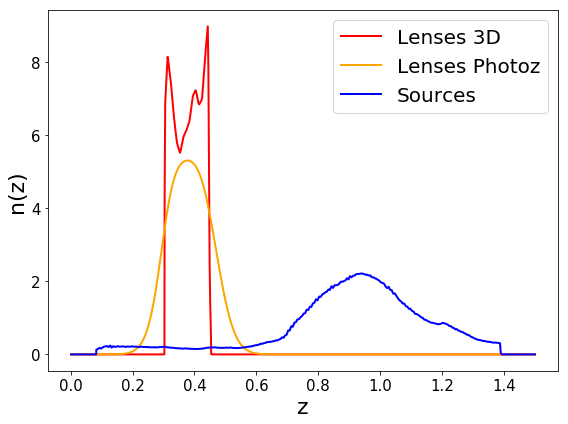

In [8]:
fig, ax_all = plt.subplots(1,1, figsize = (8,6))

ax = ax_all

ax.plot(z_array,ng_array_lens, color = 'r',lw=2, marker='',linestyle='-',label=r'Lenses 3D')
ax.plot(z_array,ng_array_lens_pz, color = 'orange',lw=2, marker='',linestyle='-',label=r'Lenses Photoz')
# ax.plot(z_array,ng_array_lens_specz, color = 'k',lw=2, marker='',linestyle='-',label=r'Lenses Specz')

ax.plot(z_array,ng_array_source, color = 'b',lw=2, marker='',linestyle='-',label=r'Sources')

ax.set_ylabel(r'n(z)', size = 22)
ax.set_xlabel(r'z', size = 22)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)  
ax.legend(fontsize=20)

plt.tight_layout()
# plt.savefig('nz_comp.png')





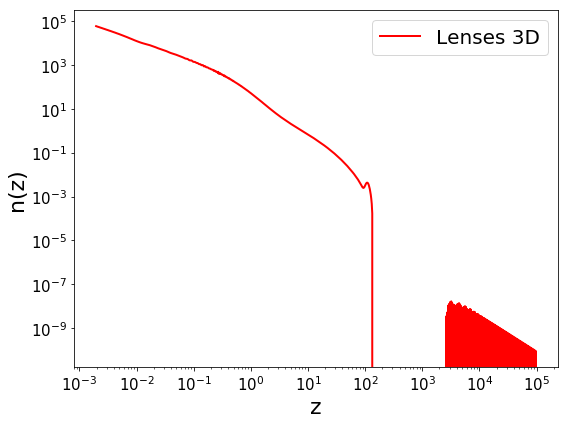

In [9]:
fig, ax_all = plt.subplots(1,1, figsize = (8,6))

ax = ax_all

ax.plot(nc.r_array,nc.xi_gg[0,:], color = 'r',lw=2, marker='',linestyle='-',label=r'Lenses 3D')
# ax.plot(z_array,ng_array_lens_pz, color = 'orange',lw=2, marker='',linestyle='-',label=r'Lenses Photoz')
# # ax.plot(z_array,ng_array_lens_specz, color = 'k',lw=2, marker='',linestyle='-',label=r'Lenses Specz')

# ax.plot(z_array,ng_array_source, color = 'b',lw=2, marker='',linestyle='-',label=r'Sources')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'n(z)', size = 22)
ax.set_xlabel(r'z', size = 22)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)  
ax.legend(fontsize=20)

plt.tight_layout()
# plt.savefig('nz_comp.png')





In [36]:
# Calculate w(theta)

theta_arcmin = np.logspace(np.log10(2.5),np.log10(250),20)
theta_rad = theta_arcmin * (1./60.) * (np.pi/180.)


# r_array_hres = np.logspace(np.log10(np.min(nc.r_array)),3,5000)
r_array_hres = np.logspace(-2.8,3.0,2000)

xi_hres_th = np.zeros((len(z_array),len(r_array_hres)))
xi_hres_data = np.zeros((len(z_array),len(r_array_hres)))
xi_data_interp = interpolate.interp1d(np.log10(nc.r_obs_new[0]), np.log10((nc.data_obs_new[0:20])), fill_value='extrapolate')
xi_data_nc = 10**(xi_data_interp(np.log10(nc.r_array)))
xi_data = (np.tile( (xi_data_nc), (len(z_array),1)))*nc.xi_mm

for j in range(len(z_array)):
    xi_interp = interpolate.interp1d(np.log10(nc.r_array), (nc.xi_gg[j,:]), fill_value='extrapolate')
    xi_hres_th[j,:] = (xi_interp(np.log10(r_array_hres)))

    xi_interp = interpolate.interp1d(np.log10(nc.r_array), (xi_data[j,:]), fill_value='extrapolate')
    xi_hres_data[j,:] = (xi_interp(np.log10(r_array_hres)))

wtheta_th = np.zeros(len(theta_rad)) #bestfit theory w(theta)
# wtheta_th_pz = np.zeros(len(theta_rad)) #bestfit theory w(theta)
wtheta_data = np.zeros(len(theta_rad)) #data w(theta)
wtheta_th_pk = np.zeros(len(theta_rad))

for j in range(len(theta_rad)):    
    print j 
    wtheta_th[j] = get_wtheta_from_xi(theta_rad[j], r_array_hres, xi_hres_th, z_array, ng_array_lens, chi_array, dchi_dz_array)
#     wtheta_th_pz[j] = get_wtheta_from_xi(theta_rad[j], r_array_hres, xi_hres_th, z_array, ng_array_lens_pz, chi_array, dchi_dz_array)

    wtheta_data[j] = get_wtheta_from_xi(theta_rad[j], r_array_hres, xi_hres_data, z_array, ng_array_lens, chi_array, dchi_dz_array)
#     wtheta_th_pk[j] = get_wtheta_from_Pk(theta_rad[j], nc.k_hres, nc.Pk_gg, z_array, ng_array_lens, chi_array, dchi_dz_array)

     


        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [10]:
# # Calculate w(theta) by powerspec directly:

# def get_wtheta_from_Pk_limber(theta_rad, k_array, Pk_array, z_array, ng_array, chi_array, dchi_dz_array):
    
#     j0_integral = np.zeros(len(chi_array))
    
#     for j in range(len(chi_array)):
#         chi = chi_array[j]
#         j0_integrand = k_array * Pk_array * sp.special.jv(0, k_array * (chi*theta_rad))
#         j0_integral[j] = (1./(2.*np.pi)) * sp.integrate.simps(j0_integrand,k_array)
    
#     z_integral = (ng_array ** 2) * j0_integral / dchi_dz_array 
#     wt_val = sp.integrate.simps(z_integral, z_array)
#     return wt_val


# wtheta_th_lim = np.zeros(len(theta_rad))

# for j in range(len(theta_rad)):    
#     wtheta_th_lim[j] = get_wtheta_from_Pk_limber(theta_rad[j], nc.k_hres, nc.Pk_gg, z_array, ng_array_lens, chi_array, dchi_dz_array)

    
    

In [11]:
# wt_mice_des = np.loadtxt('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/wt_mice_des_y1_3_3.txt', delimiter=',')
# theta_mice_des, theta_wt_mice_des = wt_mice_des[:,0],wt_mice_des[:,1]

# wt_des = np.loadtxt('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/wt_des_y1_3_3.txt', delimiter=',')
# theta_des, theta_wt_des = wt_des[:,0],wt_des[:,1]




In [12]:
# fig, ax_all = plt.subplots(1,1, figsize = (8,6))

# ax = ax_all

# ax.plot(theta_arcmin,theta_arcmin*wtheta_th, color = 'r',lw=2, marker='',linestyle='-',label=r'with specz')
# ax.plot(theta_arcmin,theta_arcmin*wtheta_th_pz, color = 'b',lw=2, marker='',linestyle='-',label=r'with photoz')
# ax.plot(theta_des,theta_wt_des, color = 'k',lw=2, marker='',linestyle='--',label=r'DES Y1')
# ax.plot(theta_mice_des,theta_wt_mice_des, color = 'k',lw=2, marker='',linestyle=':',label=r'MICE Y1')

# ax.set_xscale('log')
# # ax.set_yscale('log')
# ax.set_ylabel(r'$\theta \ w(\theta)$', size = 22)
# ax.set_xlabel(r'$\theta$', size = 22)
# ax.tick_params(axis='both', which='major', labelsize=15)
# ax.tick_params(axis='both', which='minor', labelsize=15)  
# ax.legend(fontsize=20, frameon=False)
# ax.set_xlim(3,100)
# ax.set_ylim(0.2,2.2)

# plt.tight_layout()
# plt.savefig('wtheta_specz_vs_photoz.png')








In [19]:
# (1/2*pi)*int dy y J_2(y*rp) P_gm(y) = Delta w_p(r_p)
def get_Deltawp_from_Pk(rp_array,k, Pk):
    k_mat = np.tile(k.reshape(1,len(k)),(len(rp_array),1))
    
    rp_mat = np.tile(rp_array.reshape(len(rp_array),1),(1,len(k)))
    J2_mat = sp.special.jv(2, k_mat * rp_mat)
    Deltawprp_array = (sp.integrate.simps(k_mat * Pk * J2_mat, k)) / (2 * np.pi)
    
    return Deltawprp_array

def get_Delta_wp(rp_array, r_array,xi_mat):
    
    r_mat = np.tile(r_array.reshape(1,len(r_array)),(len(rp_array),1))
    rp_mat = np.tile(rp_array.reshape(len(rp_array),1),(1,len(r_array)))
    invdenom1 = 1./(r_mat**2 - rp_mat**2)
    ind = np.where(invdenom1 <= 0)
    invdenom1[ind] = 0.0
    integrand = r_mat * xi_mat*(np.sqrt(invdenom1))
    wprp_array = 2.*sp.integrate.simps(integrand,r_array)
    
    wprp_interp = interpolate.interp1d(rp_array,np.log(wprp_array),fill_value='extrapolate')
    
    wprp_mean = np.zeros(len(rp_array))
    for j in range(len(rp_array)):
        rp_ti = np.logspace(-3.5,np.log10(rp_array[j]),5000)
        wprp_ti = np.exp(wprp_interp(rp_ti))
        wprp_mean[j] = sp.integrate.simps(rp_ti * wprp_ti, rp_ti)/sp.integrate.simps(rp_ti , rp_ti)
    
    Delta_wp = wprp_mean - wprp_array

    return Delta_wp




In [20]:
# Calculate Sigma_crit
# when lens redshift > source redshift, set sigma_crit to high value so that gamma_t is zero


# Dcom_interp = interpolate.interp1d(z_array,chi_array)
# invsig_crit_rhom = np.zeros((len(z_array),len(z_array)))

# # invcoeff_sigcrit = ((const.c ** 2)/(4 * np.pi * const.G * (1.0 * u.Mpc/h))).to(u.kg/u.m**2).value
# invcoeff_sigcrit = 3*(100**2) * cosmo.Om0 /(2. * ((3*10**5) **2 ) ) 
# z_lmat = np.tile(z_array.reshape(len(z_array),1), (1,len(z_array)) )
# z_smat = np.tile(z_array.reshape(1,len(z_array)), (len(z_array),1) )

# chi_lmat = np.tile(chi_array.reshape(len(z_array),1), (1,len(z_array)) )
# chi_smat = np.tile(chi_array.reshape(1,len(z_array)), (len(z_array),1) )
# DA_l = (chi_lmat*(1. + z_lmat))
# DA_s = (chi_smat * (1. + z_smat))
# DA_ls = ( (chi_smat- chi_lmat) * (1. + z_smat))
# sig_crit_mat =  (coeff_sigcrit * (DA_s)/(DA_l * DA_ls))
# ind_lz = np.where(DA_ls <= 0)
# sig_crit_mat[ind_lz] = 1e180


chi_lmat = np.tile(chi_array.reshape(len(z_array),1), (1,len(z_array)) )
chi_smat = np.tile(chi_array.reshape(1,len(z_array)), (len(z_array),1) )
num = chi_smat - chi_lmat
ind_lzero = np.where(num <= 0)
num[ind_lzero] = 0
ng_array_source_rep = np.tile(ng_array_source.reshape(1,len(z_array)), (len(z_array), 1))
int_sourcez = sp.integrate.simps(ng_array_source_rep * (num/ chi_smat), z_array)
coeff_ints = 3*(100**2) * cosmo.Om0 /(2. * ((3*10**5) **2 ) ) 
Is = coeff_ints * chi_array * (1. + z_array) * int_sourcez 
                
                
    

In [15]:
# # Do the integral over the source redshift, last integral in Eq.16

# ng_array_source_rep = np.tile(ng_array_source.reshape(1,len(z_array)), (len(z_array), 1))
# int_sourcez = sp.integrate.simps(ng_array_source_rep / sig_crit_mat, z_array)




In [45]:
theta_arcmin = np.logspace(np.log10(2.5),np.log10(250),20)
theta_rad = theta_arcmin * (1./60.) * (np.pi/180.)


r_array_hres = np.logspace(-2.8,3,2000)


xi_gm_hres_th = np.zeros((len(z_array),len(r_array_hres)))
xi_gm_hres_data = np.zeros((len(z_array),len(r_array_hres)))
# xi_gm_data = (np.tile( (nc.data_obs_new[20:40] ), (len(z_array),1)))*nc.xi_mm

xi_gm_data_interp = interpolate.interp1d(np.log10(nc.r_obs_new[1]), np.log10(nc.data_obs_new[20:40]), fill_value='extrapolate')
xi_gm_data_nc = 10**(xi_gm_data_interp(np.log10(nc.r_array)))
xi_gm_data = (np.tile( (xi_gm_data_nc), (len(z_array),1)))*nc.xi_mm

for j in range(len(z_array)):
    xi_interp = interpolate.interp1d(np.log10(nc.r_array), (nc.xi_gm[j,:]), fill_value='extrapolate')
    xi_gm_hres_th[j,:] = (xi_interp(np.log10(r_array_hres)))

    xi_interp = interpolate.interp1d(np.log10(nc.r_array), (xi_gm_data[j,:]), fill_value='extrapolate')
    xi_gm_hres_data[j,:] = (xi_interp(np.log10(r_array_hres)))





In [17]:
# Calculate gamma_t

# (1/2*pi)*int dy y J_2(y*rp) P_gm(y) = Delta w_p(r_p)


# gtheta_data = np.zeros(len(theta_rad)) #bestfit theory gamma_t
# gtheta_th = np.zeros(len(theta_rad)) #data gamma_t
# # gtheta_th_pk = np.zeros(len(theta_rad)) #data gamma_t
# # gtheta_th_pz = np.zeros(len(theta_rad))

# # Deltawp_th_pk = np.zeros(len(z_array))



# for j1 in range(len(theta_rad)):
#     print j1
#     rp_array = chi_array*theta_rad[j1]
    
# #     Deltawp_data = get_Delta_wp(rp_array,  r_array_hres, xi_gm_hres_data, z_array)
#     Deltawp_th = get_Delta_wp(rp_array,  r_array_hres, xi_gm_hres_th)

# #     Deltawp_th_pk = get_Deltawp_from_Pk(rp_array,nc.k_hres, nc.Pk_gm)
    
# #     gtheta_data[j1] = sp.integrate.simps(ng_array_lens *Is * Deltawp_data, z_array)
#     gtheta_th[j1] = sp.integrate.simps(ng_array_lens *Is* Deltawp_th , z_array)

# #     gtheta_th_pk[j1] = sp.integrate.simps(ng_array_lens * Is * Deltawp_th_pk , z_array)
# #     gtheta_th_pz[j1] = sp.integrate.simps(rhom_z * ng_array_lens_pz * int_sourcez * Deltawp_th  * oneMpc_h, z_array)
    


    

In [46]:
def get_Delta_wp_from_xi(rp_array, r_array,xi_mat):
    
    r_mat = np.tile(r_array.reshape(1,len(r_array)),(len(rp_array),1))
    rp_mat = np.tile(rp_array.reshape(len(rp_array),1),(1,len(r_array)))
    invdenom1 = 1./(r_mat**2 - rp_mat**2)
    ind = np.where(invdenom1 <= 0)
    invdenom1[ind] = 0.0
    integrand = r_mat * xi_mat*(np.sqrt(invdenom1))
    wprp_array = 2.*sp.integrate.simps(integrand,r_array)
    
    wprp_interp = interpolate.interp1d(rp_array,np.log(wprp_array),fill_value='extrapolate')
    
    wprp_mean = np.zeros(len(rp_array))
    for j in range(len(rp_array)):
#         if np.mod(j,100) == 0:
#             print j
        rp_ti = np.logspace(-3.5,np.log10(rp_array[j]),100)
        r_mat = np.tile(r_array.reshape(1,len(r_array)),(len(rp_ti),1))
        rp_ti_mat = np.tile(rp_ti.reshape(len(rp_ti),1),(1,len(r_array)))
        xi_ti_mat = np.tile(xi_mat[j,:].reshape(1,len(r_array)),(len(rp_ti),1))
        
        invdenom1 = 1./(r_mat**2 - rp_ti_mat**2)
        ind = np.where(invdenom1 <= 0)
        invdenom1[ind] = 0.0
        integrand = 2.*r_mat * rp_ti_mat * xi_ti_mat*(np.sqrt(invdenom1))
        integrand_intr = sp.integrate.simps(integrand,r_array)
        wprp_mean[j] = sp.integrate.simps(integrand_intr, rp_ti)/sp.integrate.simps(rp_ti , rp_ti)
    
    Delta_wp = wprp_mean - wprp_array

    return Delta_wp




gtheta_data = np.zeros(len(theta_rad)) #bestfit theory gamma_t
gtheta_th = np.zeros(len(theta_rad)) #data gamma_t
# gtheta_th_pk = np.zeros(len(theta_rad)) #data gamma_t
# gtheta_th_pz = np.zeros(len(theta_rad))

# Deltawp_th_pk = np.zeros(len(z_array))



for j1 in range(len(theta_rad)):
    print j1
    rp_array = chi_array*theta_rad[j1]
    
    Deltawp_data = get_Delta_wp_from_xi(rp_array,  r_array_hres, xi_gm_hres_data)
    Deltawp_th = get_Delta_wp_from_xi(rp_array,  r_array_hres, xi_gm_hres_th)

#     Deltawp_th_pk = get_Deltawp_from_Pk(rp_array,nc.k_hres, nc.Pk_gm)
    
    gtheta_data[j1] = sp.integrate.simps(ng_array_lens *Is * Deltawp_data, z_array)
    gtheta_th[j1] = sp.integrate.simps(ng_array_lens *Is* Deltawp_th , z_array)

#     gtheta_th_pk[j1] = sp.integrate.simps(ng_array_lens * Is * Deltawp_th_pk , z_array)
#     gtheta_th_pz[j1] = sp.integrate.simps(rhom_z * ng_array_lens_pz * int_sourcez * Deltawp_th  * oneMpc_h, z_array)
    




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


/home/shivam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


18
19


In [20]:
# # wt_mice_des = np.loadtxt('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/wt_mice_des_y1_3_3.txt', delimiter=',')
# # theta_mice_des, theta_wt_mice_des = wt_mice_des[:,0],wt_mice_des[:,1]

# # wt_des = np.loadtxt('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/wt_des_y1_3_3.txt', delimiter=',')
# # theta_des, theta_wt_des = wt_des[:,0],wt_des[:,1]

# wt_cosmosis = fits.open('twopt_3d_to_2d_MICE.fits')
# # ind_sel = np.where( (wt_cosmosis['wtheta'].data['BIN1'] == 3) & (wt_cosmosis['wtheta'].data['BIN2']==3))[0]
# ind_sel = np.where( (wt_cosmosis['wtheta'].data['BIN1'] == 2) & (wt_cosmosis['wtheta'].data['BIN2'] == 2))[0]
# wtc = wt_cosmosis['wtheta'].data['VALUE'][ind_sel]
# wta = wt_cosmosis['wtheta'].data['ANG'][ind_sel]
# wtc_interp = interpolate.interp1d(wta,wtc,fill_value='extrapolate')



# fig, ax_all = plt.subplots(1,2, figsize = (14,6))

# for j in range(2):
#     ax = ax_all[j]
#     if j==0:
#         ax.plot(nc.r_obs_new[0],nc.xi_gg[0], color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
#         ax.plot(nc.r_obs_new[0],nc.data_obs_new[0:20]*nc.xi_mm[0], color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
#         ax.axvline(8., lw=2, color='k',label='Y1 Scale Cut')
#         ax.axvspan(nc.r_obs_new[0][0], 8, alpha=0.1, color='black')
#         ax.set_yscale('log')
#         ax.set_xscale('log')
#         ax.set_xlim(nc.r_obs_new[0][0],nc.r_obs_new[0][-1])
#         # ax.set_ylim(1.0,12.0)
#         ax.grid()
#         # ax.set_xlabel(r'$\theta$', size = 18)
#         ax.set_ylabel(r'$\xi^{gg}(r)$', size = 22)
#         ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
#         ax.tick_params(axis='both', which='major', labelsize=15)
#         ax.tick_params(axis='both', which='minor', labelsize=15)

#     else:
#         ax.plot(theta_arcmin,theta_arcmin*wtheta_th, color = 'r',lw=2, marker='',linestyle='-',label=r'Theory')
#         ax.plot(theta_arcmin,theta_arcmin*wtheta_data, color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
#         ax.axvline(20., lw=2, color='k',label='Y1 Scale Cut')
# #         ax.plot(theta_des,theta_wt_des, color = 'k',lw=2, marker='',linestyle='--',label=r'DES Y1')
# #         ax.plot(theta_mice_des,theta_wt_mice_des, color = 'k',lw=2, marker='',linestyle=':',label=r'MICE Y1')
#         ax.axvspan(theta_arcmin[0], 20, alpha=0.1, color='k')
#         ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
# #         ax.set_yscale('log')
#         ax.set_xscale('log')
#         ax.set_xlim(3,100)
#         ax.set_ylim(0.2,2.4)
#         # ax.set_ylim(1.0,12.0)
#         ax.grid()
#         # ax.set_xlabel(r'$\theta$', size = 18)
#         ax.set_ylabel(r'$\theta \ w(\theta)$', size = 22)
#         ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
#         ax.legend(fontsize=17,loc='upper left')
#         ax.tick_params(axis='both', which='major', labelsize=15)
#         ax.tick_params(axis='both', which='minor', labelsize=15)

        
# plt.tight_layout()
# # plt.savefig('xigg_3d_to_2d_comp_cy.png')







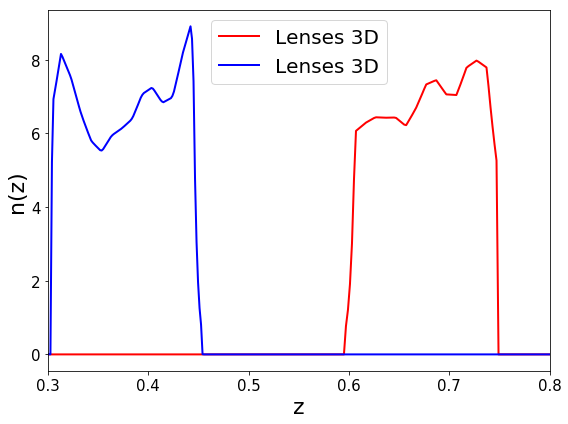

In [21]:
df = fits.open('twopt_3d_to_2d_MICE.fits')
df_zmid = df['nz_pos_zspec'].data['Z_MID']
df_bin3 = df['nz_pos_zspec'].data['BIN4']

fig, ax_all = plt.subplots(1,1, figsize = (8,6))

ax = ax_all

ax.plot(df_zmid,df_bin3, color = 'r',lw=2, marker='',linestyle='-',label=r'Lenses 3D')
ax.plot(z_array,ng_array_lens, color = 'b',lw=2, marker='',linestyle='-',label=r'Lenses 3D')
ax.set_xlim(0.3,0.8)

ax.set_ylabel(r'n(z)', size = 22)
ax.set_xlabel(r'z', size = 22)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)  
ax.legend(fontsize=20)

plt.tight_layout()




In [22]:
bin_lens


2

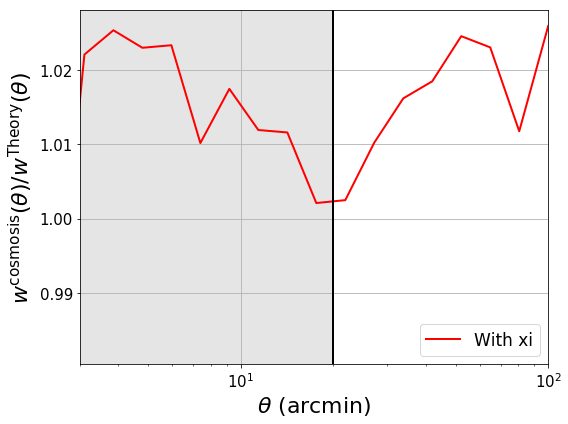

In [15]:
# output_data_gg = pk.load(open('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/wtheta_3dcorr_r_1.0_250.0_nr_20_zbin_3_jk_True_njkradec_180_njkz_1_dsg_1.pk', "rb"))   

wt_cosmosis = fits.open('twopt_3d_to_2d_MICE.fits')
# ind_sel = np.where( (wt_cosmosis['wtheta'].data['BIN1'] == 3) & (wt_cosmosis['wtheta'].data['BIN2']==3))[0]
ind_sel = np.where( (wt_cosmosis['wtheta'].data['BIN1'] == bin_lens) & (wt_cosmosis['wtheta'].data['BIN2'] == bin_lens))[0]
wtc = wt_cosmosis['wtheta'].data['VALUE'][ind_sel]
wta = wt_cosmosis['wtheta'].data['ANG'][ind_sel]
wtc_interp = interpolate.interp1d(wta,wtc,fill_value='extrapolate')

fig, ax_all = plt.subplots(1,1, figsize = (8,6))

ax = ax_all


ax.plot(theta_arcmin,wtc_interp(theta_arcmin) /wtheta_th, color = 'r',lw=2, marker='',linestyle='-', label='With xi')
# ax.plot(theta_arcmin,wtc_interp(theta_arcmin)/wtheta_th_pk, color = 'b',lw=2, marker='',linestyle='-', label='With P(k)')
ax.axvline(20., lw=2, color='k')
#         ax.errorbar(output_data_gg['r_gg'], output_data_gg['r_gg'] * output_data_gg['xi_gg_full'], output_data_gg['r_gg'] *output_data_gg['sig'], color = 'k',lw=2, marker='',linestyle='--',label=r'Data 2D')
#         ax.plot(theta_arcmin,*theta_arcmin, color = 'r',lw=2, marker='',linestyle='--',label=r'Theory Cosmosis' ) 
ax.axvspan(theta_arcmin[0], 20, alpha=0.1, color='k')
ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(3,100)
#         ax.set_ylim(0.2,2.4)
# ax.set_ylim(1.0,12.0)
ax.grid()
# ax.set_xlabel(r'$\theta$', size = 18)
ax.set_ylabel(r'$w^{\rm cosmosis}(\theta)/w^{\rm Theory}(\theta)$', size = 22)
ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
ax.legend(fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

        
plt.tight_layout()
# plt.savefig('xigg_ratio_bin'+ str(bin_lens) +'.png')









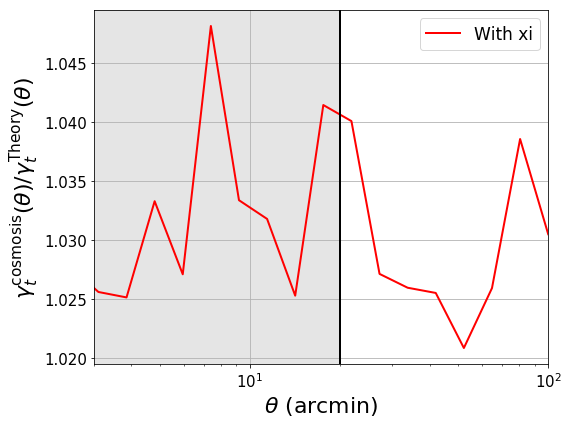

In [22]:
# output_data_gg = pk.load(open('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/wtheta_3dcorr_r_1.0_250.0_nr_20_zbin_3_jk_True_njkradec_180_njkz_1_dsg_1.pk', "rb"))   

wt_cosmosis = fits.open('twopt_3d_to_2d_MICE.fits')
ind_sel = np.where( (wt_cosmosis['gammat'].data['BIN1'] == bin_lens) & (wt_cosmosis['gammat'].data['BIN2']== bin_source))[0]
gtc = wt_cosmosis['gammat'].data['VALUE'][ind_sel]
gta = wt_cosmosis['gammat'].data['ANG'][ind_sel]
gtc_interp = interpolate.interp1d(gta,gtc,fill_value='extrapolate')

c_by_theta2 = -0.012/(theta_arcmin**2)

fig, ax_all = plt.subplots(1,1, figsize = (8,6))

ax = ax_all

ax.plot(theta_arcmin,gtc_interp(theta_arcmin)/(gtheta_th), color = 'r',lw=2, marker='',linestyle='-',label='With xi')
# ax.plot(theta_arcmin,gtc_interp(theta_arcmin)/(gtheta_th_pk), color = 'b',lw=2, marker='',linestyle='-', label='With P(k)')
ax.axvline(20., lw=2, color='k')
ax.axvspan(theta_arcmin[0], 20, alpha=0.1, color='k')
ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
#         ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(3,100)
#         ax.set_ylim(0.2,2.4)
# ax.set_ylim(1.0,12.0)
ax.grid()
# ax.set_xlabel(r'$\theta$', size = 18)
ax.set_ylabel(r'$\gamma_t^{\rm cosmosis}(\theta)/\gamma_t^{\rm Theory}(\theta)$', size = 22)
ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
ax.legend(fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

        
plt.tight_layout()
# plt.savefig('xigm_ratio_bin'+ str(bin_lens) + '_' + str(bin_source) +'.png')





In [41]:
wt_cosmosis.info()


Filename: /home/shivam/Research/cosmosis/y3kp-bias-model/3d_stats/3d_to_2d/twopt_3d_to_2d_MICE_wcov.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        13   (580, 580)   float64   
  2  gammat        1 BinTableHDU     29   400R x 5C   [K, K, K, D, D]   
  3  wtheta        1 BinTableHDU     29   180R x 5C   ['K', 'K', 'K', 'D', 'D']   
  4  nz_pos_zspec    1 BinTableHDU     26   2000R x 8C   [D, D, D, D, D, D, D, D]   
  5  nz_shear_true    1 BinTableHDU     24   266R x 7C   [D, D, D, D, D, D, D]   


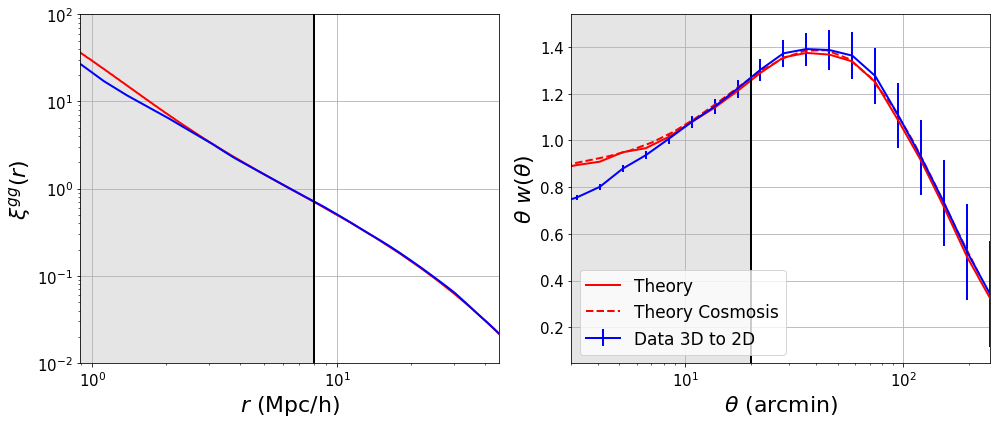

In [42]:
# output_data_gg = pk.load(open('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/wtheta_3dcorr_r_1.0_250.0_nr_20_zbin_3_jk_True_njkradec_180_njkz_1_dsg_1.pk', "rb"))   
wt_cosmosis = fits.open('/home/shivam/Research/cosmosis/y3kp-bias-model/3d_stats/3d_to_2d/twopt_3d_to_2d_MICE_wcov.fits')
# wt_cosmosis = fits.open('twopt_3d_to_2d_MICE.fits')
# ind_sel = np.where( (wt_cosmosis['wtheta'].data['BIN1'] == 3) & (wt_cosmosis['wtheta'].data['BIN2']==3))[0]
ind_sel = np.where( (wt_cosmosis['wtheta'].data['BIN1'] == bin_lens) & (wt_cosmosis['wtheta'].data['BIN2']==bin_lens))[0]
wt_cov = wt_cosmosis['COVMAT'].data[400:500,400:500]
wt_cov_bin = wt_cov[:,ind_sel][ind_sel,:]
wt_sig_bin = np.sqrt(np.diag(wt_cov_bin))

fig, ax_all = plt.subplots(1,2, figsize = (14,6))

for j in range(2):
    ax = ax_all[j]
    if j==0:
        ax.plot(nc.r_array,nc.xi_gg[zmean_ind,:], color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
        ax.plot(nc.r_array,xi_data[zmean_ind,:], color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
        ax.axvline(8., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(nc.r_obs_new[0][0], 8, alpha=0.1, color='black')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(nc.r_obs_new[0][0],nc.r_obs_new[0][-1])
        ax.set_ylim(1e-2,1e2)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\xi^{gg}(r)$', size = 22)
        ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

    else:
        ax.plot(theta_arcmin,theta_arcmin*wtheta_th, color = 'r',lw=2, marker='',linestyle='-',label=r'Theory')
        ax.errorbar(theta_arcmin,theta_arcmin*wtheta_data, theta_arcmin*wt_sig_bin, color = 'b',lw=2, marker='',linestyle='-',label=r'Data 3D to 2D')
        ax.axvline(20., lw=2, color='k')
#         ax.errorbar(output_data_gg['r_gg'], output_data_gg['r_gg'] * output_data_gg['xi_gg_full'], output_data_gg['r_gg'] *output_data_gg['sig'], color = 'k',lw=2, marker='',linestyle='--',label=r'Data 2D')
        ax.plot(wt_cosmosis['wtheta'].data['ANG'][ind_sel],wt_cosmosis['wtheta'].data['ANG'][ind_sel]*wt_cosmosis['wtheta'].data['VALUE'][ind_sel], color = 'r',lw=2, marker='',linestyle='--',label=r'Theory Cosmosis' ) 
        ax.axvspan(theta_arcmin[0], 20, alpha=0.1, color='k')
        ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
#         ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(3,250)
#         ax.set_ylim(0.2,2.4)
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\theta \ w(\theta)$', size = 22)
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ax.legend(fontsize=17,loc='lower left')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

        
plt.tight_layout()
# plt.savefig('xigg_3d_to_2d_comp_fixh.png')








In [26]:
# # gt_des = np.loadtxt('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/gt_des_mice_y1_3_4.txt', delimiter=',')
# # theta_des, theta_gt_des = gt_des[:,0],gt_des[:,1]

# gt_mice_des = np.loadtxt('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/gt_mice_des_y1_3_4.txt', delimiter=',')
# theta_mice_des, theta_gt_mice_des = gt_des[:,0],gt_des[:,1]

# # Subtract the 1-halo term from the theory to match data
# c_by_theta2 = -0.03/(theta_arcmin**2)

# fig, ax_all = plt.subplots(1,2, figsize = (14,6))

# for j in range(2):
#     ax = ax_all[j]
#     if j==0:
#         ax.plot(nc.r_obs_new[1],nc.xi_gm[0], color = 'r',lw=2, marker='',linestyle='-',label=r'Theory')
#         ax.plot(nc.r_obs_new[1],nc.data_obs_new[20:40]*nc.xi_mm[0], lw=2,color = 'b', marker='',linestyle='-',label=r'Data')
#         ax.axvline(12., lw=2, color='k',label='Y1 Scale Cut')
#         ax.axvspan(nc.r_obs_new[0][0], 12, alpha=0.1, color='black')
#         ax.set_yscale('log')
#         ax.set_xscale('log')
#         ax.set_xlim(nc.r_obs_new[0][0],nc.r_obs_new[0][-1])
#         # ax.set_ylim(1.0,12.0)
#         ax.grid()
#         # ax.set_xlabel(r'$\theta$', size = 18)
#         ax.set_ylabel(r'$\xi^{gm}(r)$', size = 22)
#         ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
#         ax.tick_params(axis='both', which='major', labelsize=15)
#         ax.tick_params(axis='both', which='minor', labelsize=15)
       
# #         ax.legend(fontsize=20)
#     else:
#         ax.plot(theta_arcmin,(theta_arcmin**0.7)*gtheta_th, color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
# #         ax.plot(theta_arcmin,c_by_theta2, color = 'g', lw=2,marker='',linestyle='--',label=r'$c/\theta^2$')
#         ax.plot(theta_arcmin,(theta_arcmin**0.7)*(gtheta_th + c_by_theta2), color = 'orange', lw=2,marker='',linestyle='-',label=r'Theory + ' + r'$c/\theta^2$')
#         ax.plot(theta_arcmin,(theta_arcmin**0.7)*(gtheta_th_pz + c_by_theta2), color = 'orange', lw=2,marker='',linestyle='--',label=r'Theory pz + ' + r'$c/\theta^2$')
#         ax.plot(theta_arcmin,(theta_arcmin**0.7)*gtheta_data, color = 'b', lw=2,marker='',linestyle='-',label=r'Data')
#         ax.axvline(30., lw=2, color='k',label='Y1 Scale Cut')
#         ax.plot(theta_mice_des, theta_gt_mice_des, color = 'k', lw=2,marker='',linestyle='--',label=r'MICE Y1')
#         ax.axvspan(theta_arcmin[0], 30, alpha=0.1, color='k')
#         ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
# #         ax.set_yscale('log')
#         ax.set_xscale('log')
#         ax.set_ylim(0.0,0.0175)
#         ax.grid()
#         # ax.set_xlabel(r'$\theta$', size = 18)
#         ax.set_ylabel(r'$\theta^{0.7} \ \gamma^{3,4}_t(\theta)$', size = 22)
#         ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
#         ax.legend(fontsize=17)
#         ax.tick_params(axis='both', which='major', labelsize=15)
#         ax.tick_params(axis='both', which='minor', labelsize=15)

        
        

# plt.tight_layout()
# plt.savefig('xigm_3d_to_2d_comp_cy.png')









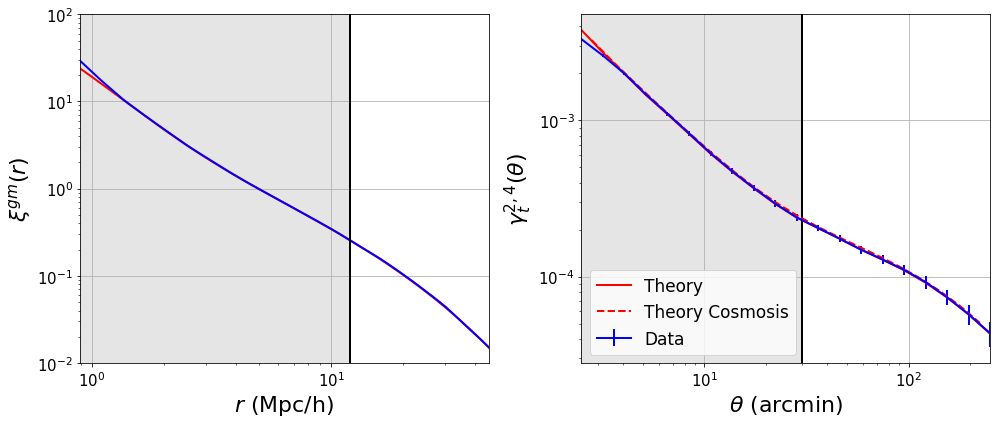

In [48]:
# gt_des = np.loadtxt('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/gt_des_mice_y1_3_4.txt', delimiter=',')
# theta_des, theta_gt_des = gt_des[:,0],gt_des[:,1]

wt_cosmosis = fits.open('/home/shivam/Research/cosmosis/y3kp-bias-model/3d_stats/3d_to_2d/twopt_3d_to_2d_MICE_wcov.fits')


# wt_cosmosis = fits.open('twopt_3d_to_2d_MICE.fits')
ind_sel = np.where( (wt_cosmosis['gammat'].data['BIN1'] == bin_lens) & (wt_cosmosis['gammat'].data['BIN2']== bin_source))[0]
gt_cov = wt_cosmosis['COVMAT'].data[0:400,0:400]
gt_cov_bin = gt_cov[:,ind_sel][ind_sel,:]
gt_sig_bin = np.sqrt(np.diag(gt_cov_bin))
# Subtract the 1-halo term from the theory to match data
const = 0.015
c_by_theta2 = const/(theta_arcmin**2)

fig, ax_all = plt.subplots(1,2, figsize = (14,6))

for j in range(2):
    ax = ax_all[j]
    if j==0:
        ax.plot(nc.r_array,nc.xi_gm[zmean_ind,:], color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
        ax.plot(nc.r_array,xi_gm_data[zmean_ind,:], color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
        ax.axvline(12., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(nc.r_obs_new[0][0], 12, alpha=0.1, color='black')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(nc.r_obs_new[0][0],nc.r_obs_new[0][-1])
        ax.set_ylim(1e-2,1e2)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\xi^{gm}(r)$', size = 22)
        ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)
       
#         ax.legend(fontsize=20)
    else:
#         ax.plot(theta_arcmin,gtheta_th , color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
        ax.plot(theta_arcmin,(gtheta_th + c_by_theta2) , color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
#         ax.plot(theta_arcmin,c_by_theta2, color = 'g', lw=2,marker='',linestyle='--',label=r'$c/\theta^2$')
#         ax.plot(theta_arcmin,(theta_arcmin**0.7)*(gtheta_th + c_by_theta2), color = 'orange', lw=2,marker='',linestyle='-',label=r'Theory + ' + r'$c/\theta^2$')
#         ax.plot(theta_arcmin,(theta_arcmin**0.7)*(gtheta_th_pz + c_by_theta2), color = 'orange', lw=2,marker='',linestyle='--',label=r'Theory pz + ' + r'$c/\theta^2$')
        ax.errorbar(theta_arcmin,gtheta_data, gt_sig_bin, color = 'b', lw=2,marker='',linestyle='-',label=r'Data')
        ax.axvline(30., lw=2, color='k')
        ax.plot(wt_cosmosis['gammat'].data['ANG'][ind_sel],wt_cosmosis['gammat'].data['VALUE'][ind_sel] + ( const/wt_cosmosis['gammat'].data['ANG'][ind_sel]**2), color = 'r',lw=2, marker='',linestyle='--',label=r'Theory Cosmosis' ) 
        
        ax.axvspan(theta_arcmin[0], 30, alpha=0.1, color='k')
        ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
        ax.set_yscale('log')
        ax.set_xscale('log')
#         ax.set_ylim(0.0,0.006)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\gamma^{2,4}_t(\theta)$', size = 22)
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ax.legend(fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

        
        

plt.tight_layout()
# plt.savefig('xigm_3d_to_2d_comp_fixh.png')










XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  900                                                  
NAXIS2  =                  900                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COVDATA =                    T                                                  
EXTNAME = 'COVMAT  '                                                            
STRT_0  =                    0                                                  
NAME_0  = 'xip     '                                                            
STRT_1  =                  200                                                  
NAME_1  = 'xim     '        

In [61]:
nz_dir = '/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/nz_data/'
bins_array = np.arange(0,5) + 1
for bins in [bins_array[0]]:
    filename_nzlens = nz_dir + 'nz_g_m_' + '_zbin_' + str(bins) + '_dsg_' + str(1) + '_dsm_' + str(1) + '.pk'
    nz_data = pk.load(open(filename_nzlens, 'rb'))
    nz_g, nz_m, nz_z = nz_data['nz_g'], nz_data['nz_m'], nz_data['nz_z']

    


    



In [70]:
nz_g


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.15386833,
        1.76918386,  2.2485717 ,  3.1020641 ,  4.52293325,  5.37126768,
        5.86491579,  6.46354377,  7.31582253,  7.94327446,  9.12839402,
        9.17602939, 10.07169579, 11.12695586, 12.22590697,  2.51557252,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [63]:
zmid = nz_z
zlow = zmid - (zmid[1] - zmid[0])
zhigh = zmid + (zmid[1] - zmid[0])



In [88]:
with fits.open('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/twopt_mice_y1_specz_mod.fits', mode='update') as hdul:
    for bins in bins_array:
        filename_nzlens = nz_dir + 'nz_g_m_' + '_zbin_' + str(bins) + '_dsg_' + str(1) + '_dsm_' + str(1) + '.pk'
        nz_data = pk.load(open(filename_nzlens, 'rb'))
        nz_g, nz_m, nz_z = nz_data['nz_g'], nz_data['nz_m'], nz_data['nz_z']
        nz_interp = interpolate.interp1d(nz_z,np.log(nz_g + 1e-80),fill_value='extrapolate')
        zmid = hdul['nz_pos_zspec'].data['Z_MID']
        nz_zmid = np.exp(nz_interp(zmid))
        hdul['nz_pos_zspec'].data['BIN' + str(bins)] = nz_zmid
    hdul.flush()





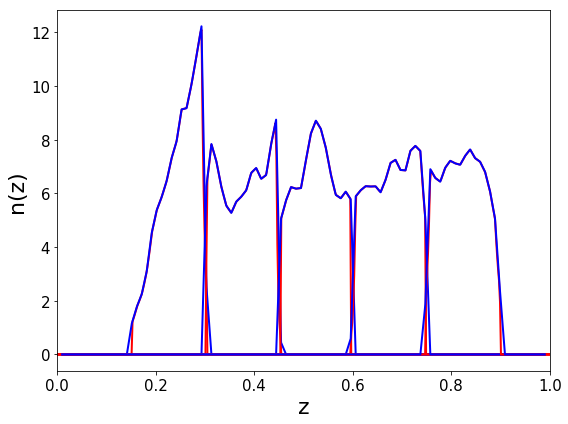

In [89]:

twopt_new = fits.open('/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/twopt_mice_y1_specz_mod.fits')
zmid = twopt_new['nz_pos_zspec'].data['Z_MID']
bin1 = twopt_new['nz_pos_zspec'].data['BIN1']

fig, ax_all = plt.subplots(1,1, figsize = (8,6))

ax = ax_all
for bins in bins_array:
    filename_nzlens = nz_dir + 'nz_g_m_' + '_zbin_' + str(bins) + '_dsg_' + str(1) + '_dsm_' + str(1) + '.pk'
    nz_data = pk.load(open(filename_nzlens, 'rb'))
    nz_g, nz_m, nz_z = nz_data['nz_g'], nz_data['nz_m'], nz_data['nz_z']
    ax.plot(zmid,twopt_new['nz_pos_zspec'].data['BIN' + str(bins)], color = 'r',lw=2, marker='',linestyle='-')
    ax.plot(nz_z,nz_g, color = 'b',lw=2, marker='',linestyle='-')

ax.set_ylabel(r'n(z)', size = 22)
ax.set_xlabel(r'z', size = 22)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)  
ax.legend(fontsize=20)

plt.tight_layout()
# plt.savefig('nz_comp.png')








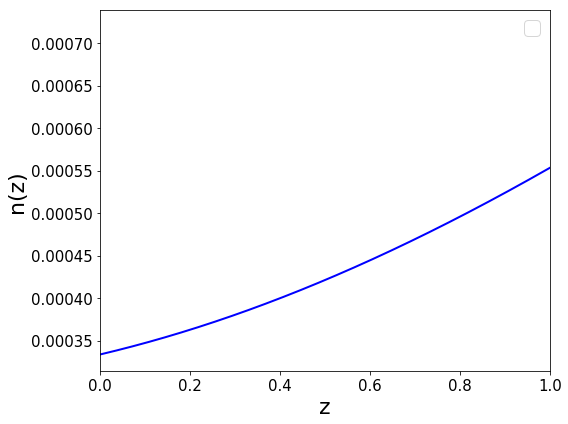

In [16]:


fig, ax_all = plt.subplots(1,1, figsize = (8,6))

ax = ax_all

ax.plot(z_array, 1./dchi_dz_array, color = 'b',lw=2, marker='',linestyle='-')

ax.set_ylabel(r'n(z)', size = 22)
ax.set_xlabel(r'z', size = 22)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)  
ax.legend(fontsize=20)

plt.tight_layout()
# plt.savefig('nz_comp.png')












